# NFL Combine Analysis
## 2010-2020

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from scipy.stats import levene
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Load Data:

### Import NFL Combine results from 2010-2020

In [102]:
combine10 = pd.read_csv("Files\combine2010.csv")
combine11 = pd.read_csv("Files\combine2011.csv")
combine12 = pd.read_csv("Files\combine2012.csv")
combine13 = pd.read_csv("Files\combine2013.csv")
combine14 = pd.read_csv("Files\combine2014.csv")
combine15 = pd.read_csv("Files\combine2015.csv")
combine16 = pd.read_csv("Files\combine2016.csv")
combine17 = pd.read_csv("Files\combine2017.csv")
combine18 = pd.read_csv("Files\combine2018.csv")
combine19 = pd.read_csv("Files\combine2019.csv")
combine20 = pd.read_csv("Files\combine2020.csv")

### Join all the results into one dataframe, rename columns, and get rid of the "College" column 

In [135]:
df = pd.concat([combine12,combine13,combine14,combine15,combine16,combine17,combine18,combine18,combine20])
df.columns = ['Player', 'Position', 'School', 'College', 'Height', 'Weight', '40Yard', 'Vertical', 
              'Bench', 'Broad', '3Cone', 'Shuttle', 'Drafted']
del df['College']

### Show data

In [136]:
df.head()

,Player,Position,School,Height,Weight,40Yard,Vertical,Bench,Broad,3Cone,Shuttle,Drafted
0,Emmanuel Acho\AchoEm00,OLB,Texas,6-2,238,4.64,35.5,24.0,118.0,NaN,NaN,Cleveland Browns / 6th / 204th pick / 2012
1,Mike Adams\AdamMi02,OT,Ohio State,6-7,323,5.28,28.5,19.0,100.0,7.94,4.95,Pittsburgh Steelers / 2nd / 56th pick / 2012
2,Joe Adams\AdamJo01,WR,Arkansas,5-11,179,4.51,36.0,NaN,123.0,7.09,NaN,Carolina Panthers / 4th / 104th pick / 2012
3,Chas Alecxih\AlecCh00,DT,Pittsburgh,6-4,296,5.31,25.5,19.0,99.0,7.74,4.62,NaN
4,Frank Alexander\AlexFr00,DE,Oklahoma,6-4,270,4.80,NaN,NaN,NaN,NaN,NaN,Carolina Panthers / 4th / 103rd pick / 2012


### Drop duplicate rows

In [137]:
df = df.drop_duplicates(subset = "Player")

### Clean up Player column

In [138]:
df[['Name', 'ID']] = df.Player.apply(lambda x: pd.Series(str(x).split("\\")))
del df['Player']
del df['ID']

### Clean up Drafted column to be binary

In [139]:
df['Drafted'] = df['Drafted'].notnull().astype(int)

In [140]:
df

,Position,School,Height,Weight,40Yard,Vertical,Bench,Broad,3Cone,Shuttle,Drafted,Name
0,OLB,Texas,6-2,238,4.64,35.5,24.0,118.0,NaN,NaN,1,Emmanuel Acho
1,OT,Ohio State,6-7,323,5.28,28.5,19.0,100.0,7.94,4.95,1,Mike Adams
2,WR,Arkansas,5-11,179,4.51,36.0,NaN,123.0,7.09,NaN,1,Joe Adams
3,DT,Pittsburgh,6-4,296,5.31,25.5,19.0,99.0,7.74,4.62,0,Chas Alecxih
4,DE,Oklahoma,6-4,270,4.80,NaN,NaN,NaN,NaN,NaN,1,Frank Alexander
...,...,...,...,...,...,...,...,...,...,...,...,...
332,DL,South Carolina,6-5,258,4.73,34.5,20.0,123.0,7.25,4.44,1,D.J. Wonnum
333,TE,Tennessee,6-4,261,4.92,35.0,NaN,119.0,NaN,NaN,0,Dom Wood-Anderson
334,LB,Utah State,6-2,230,4.79,33.5,16.0,114.0,7.34,4.37,0,David Woodward
335,DL,Ohio State,6-5,264,NaN,NaN,NaN,NaN,NaN,NaN,1,Chase Young


## Data Exploration:

###  Check position levels

In [109]:
df.Position.value_counts()

WR      377
CB      289
RB      238
DT      181
OT      175
DE      172
OLB     155
TE      142
QB      137
OG      126
ILB     102
SS       75
FS       62
C        60
OL       54
S        53
P        52
LB       47
DL       46
K        35
FB       26
EDGE     23
LS       10
NT        3
DB        2
Name: Position, dtype: int64

### Remove DB and NT for insufficient data (DB's are either CB or FS/SS anyway)

In [141]:
df = df[df.Position != 'DB']
df = df[df.Position != 'NT']

### Get number and percent of missing values by column

In [112]:
df.isnull().sum().sort_values(ascending=False)

3Cone       1028
Shuttle      971
Bench        747
Broad        587
Vertical     552
40Yard       202
Name           0
Drafted        0
Weight         0
Height         0
School         0
Position       0
dtype: int64

In [113]:
(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

3Cone       0.389837
Shuttle     0.368221
Bench       0.283276
Broad       0.222601
Vertical    0.209329
40Yard      0.076602
Name        0.000000
Drafted     0.000000
Weight      0.000000
Height      0.000000
School      0.000000
Position    0.000000
dtype: float64

### Check descriptive statistics and correlation matrix

In [115]:
df.describe()

,Weight,40Yard,Vertical,Bench,Broad,3Cone,Shuttle,Drafted
count,2637.000000,2435.000000,2085.000000,1890.000000,2050.000000,1609.000000,1666.000000,2637.000000
mean,242.424346,4.773860,32.714149,20.054497,115.697073,7.255923,4.406573,0.657565
std,45.047884,0.298383,4.180123,6.399998,9.230916,0.407333,0.263399,0.474614
min,156.000000,4.220000,17.500000,3.000000,82.000000,6.280000,3.810000,0.000000
25%,205.000000,4.540000,30.000000,15.000000,110.000000,6.960000,4.210000,0.000000
50%,232.000000,4.690000,33.000000,20.000000,117.000000,7.160000,4.360000,1.000000
75%,277.000000,4.960000,35.500000,24.000000,122.000000,7.500000,4.560000,1.000000
max,369.000000,5.850000,45.000000,44.000000,147.000000,8.720000,5.380000,1.000000


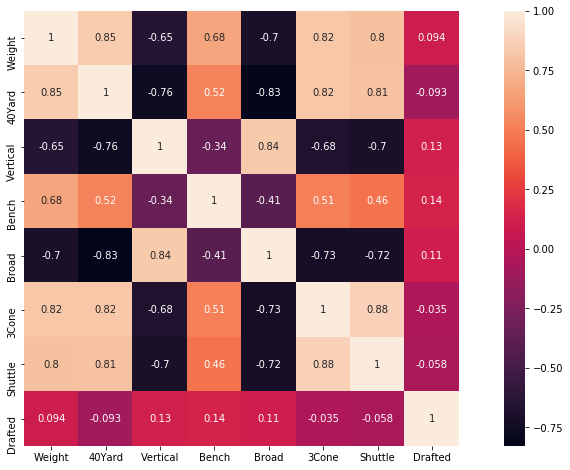

In [62]:
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(), annot=True, square=True);

#### Some notable relationships between variables: As 3Cone time goes up, so does Shuttle time. This makes sense since they are similar tests. Also, as 40Yard time goes up (slower time), Broad goes down (broad jump distance). Finally, as 40Yard time goes up, weight goes up. All these correlations make sense to me and seem accurate.

### Check unique values by column

In [117]:
df.apply(pd.Series.nunique).sort_values(ascending=False)

Name        2623
School       234
3Cone        192
Weight       190
40Yard       140
Shuttle      130
Broad         56
Vertical      54
Bench         39
Position      23
Height        18
Drafted        2
dtype: int64

### Check position group numbers before imputation

In [118]:
df.groupby('Position').count()

,School,Height,Weight,40Yard,Vertical,Bench,Broad,3Cone,Shuttle,Drafted,Name
Position,,,,,,,,,,,
C,60,60,60,56,44,50,43,42,43,60,60
CB,289,289,289,276,234,227,232,172,179,289,289
DE,172,172,172,165,141,136,139,123,124,172,172
DL,46,46,46,38,32,38,29,27,26,46,46
DT,181,181,181,172,141,142,138,127,129,181,181
EDGE,23,23,23,19,17,17,18,11,12,23,23
FB,26,26,26,25,21,22,21,19,19,26,26
FS,62,62,62,58,49,50,49,39,38,62,62
ILB,102,102,102,91,81,82,81,53,60,102,102


In [65]:
df.groupby('Position').median()

,Weight,40Yard,Vertical,Bench,Broad,3Cone,Shuttle,Drafted
Position,,,,,,,,
C,305.5,5.240,26.50,25.0,102.0,7.750,4.700,1.0
CB,193.0,4.500,35.50,15.0,122.0,6.935,4.180,1.0
DE,269.0,4.830,32.50,23.0,116.0,7.250,4.415,1.0
DL,289.5,4.900,30.25,24.0,114.0,7.470,4.520,1.0
DT,307.0,5.070,29.00,28.0,105.0,7.680,4.630,1.0
EDGE,251.0,4.760,33.00,23.0,119.0,7.140,4.280,1.0
FB,240.5,4.750,33.00,23.5,115.0,7.240,4.340,0.5
FS,206.5,4.580,35.00,16.0,121.0,7.010,4.185,1.0
ILB,240.0,4.760,32.50,20.5,117.0,7.150,4.315,1.0


## Data Cleaning:

### Kickers and punters are missing most of their testing data so removing

In [142]:
df = df[df.Position != 'K']
df = df[df.Position != 'P']

### Delete rows where athlete missed > 2 tests

In [143]:
df = df.dropna(subset = ['40Yard', 'Vertical', 'Bench', 'Broad', '3Cone', 'Shuttle'], thresh = 4)

### Imputate with their position medians

In [144]:
df['40Yard'] = df['40Yard'].fillna(df.groupby('Position')['40Yard'].transform('median'))
df['Vertical'] = df['Vertical'].fillna(df.groupby('Position')['Vertical'].transform('median'))
df['Bench'] = df['Bench'].fillna(df.groupby('Position')['Bench'].transform('median'))
df['Broad'] = df['Broad'].fillna(df.groupby('Position')['Broad'].transform('median'))
df['3Cone'] = df['3Cone'].fillna(df.groupby('Position')['3Cone'].transform('median'))
df['Shuttle'] = df['Shuttle'].fillna(df.groupby('Position')['Shuttle'].transform('median'))

### Convert height to inches for analysis (from 6-2 format into 74)

In [145]:
df[['Feet','Inches']] = df['Height'].str.split('-', 1, expand=True)
df.Feet = df.Feet.astype(int)
df.Inches = df.Inches.astype(int)
df['Height'] = (12 * df['Feet']) + df['Inches']

### Delete columns that are not needed

In [146]:
del df['Feet']
del df['Inches']

In [147]:
df

,Position,School,Height,Weight,40Yard,Vertical,Bench,Broad,3Cone,Shuttle,Drafted,Name
0,OLB,Texas,74,238,4.64,35.5,24.0,118.0,7.11,4.310,1,Emmanuel Acho
1,OT,Ohio State,79,323,5.28,28.5,19.0,100.0,7.94,4.950,1,Mike Adams
2,WR,Arkansas,71,179,4.51,36.0,14.0,123.0,7.09,4.220,1,Joe Adams
3,DT,Pittsburgh,76,296,5.31,25.5,19.0,99.0,7.74,4.620,0,Chas Alecxih
5,OT,Illinois,76,307,5.17,27.5,26.0,102.0,8.01,4.900,1,Jeff Allen
...,...,...,...,...,...,...,...,...,...,...,...,...
330,LS,Iowa State,76,235,4.76,26.0,18.0,120.0,7.12,4.280,0,Steven Wirtel
331,TE,Georgia,77,244,4.78,34.5,21.0,120.0,7.18,4.460,1,Charlie Woerner
332,DL,South Carolina,77,258,4.73,34.5,20.0,123.0,7.25,4.440,1,D.J. Wonnum
334,LB,Utah State,74,230,4.79,33.5,16.0,114.0,7.34,4.370,0,David Woodward


### One hot encode the "Position" column

In [148]:
dfohe = pd.get_dummies(df.drop(['School','Name'], axis=1), drop_first=True)

In [149]:
dfohe

,Height,Weight,40Yard,Vertical,Bench,Broad,3Cone,Shuttle,Drafted,Position_CB,...,Position_OG,Position_OL,Position_OLB,Position_OT,Position_QB,Position_RB,Position_S,Position_SS,Position_TE,Position_WR
0,74,238,4.64,35.5,24.0,118.0,7.11,4.310,1,0,...,0,0,1,0,0,0,0,0,0,0
1,79,323,5.28,28.5,19.0,100.0,7.94,4.950,1,0,...,0,0,0,1,0,0,0,0,0,0
2,71,179,4.51,36.0,14.0,123.0,7.09,4.220,1,0,...,0,0,0,0,0,0,0,0,0,1
3,76,296,5.31,25.5,19.0,99.0,7.74,4.620,0,0,...,0,0,0,0,0,0,0,0,0,0
5,76,307,5.17,27.5,26.0,102.0,8.01,4.900,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,76,235,4.76,26.0,18.0,120.0,7.12,4.280,0,0,...,0,0,0,0,0,0,0,0,0,0
331,77,244,4.78,34.5,21.0,120.0,7.18,4.460,1,0,...,0,0,0,0,0,0,0,0,1,0
332,77,258,4.73,34.5,20.0,123.0,7.25,4.440,1,0,...,0,0,0,0,0,0,0,0,0,0
334,74,230,4.79,33.5,16.0,114.0,7.34,4.370,0,0,...,0,0,0,0,0,0,0,0,0,0


### Get numerical columns for normalization

In [150]:
normCols = ['Height', 'Weight', '40Yard', 'Vertical', 'Bench', 'Broad', '3Cone', 'Shuttle']
dfnorm = df[normCols]

### Normalize

In [151]:
dfnorm=(dfnorm-dfnorm.mean())/dfnorm.std()

### Join dataframes from above

In [153]:
dfclean = pd.concat([dfohe.drop(normCols, axis=1), dfnorm], axis = 1)
dfclean = dfclean.dropna()

### Show data

In [154]:
dfclean.head()

,Drafted,Position_CB,Position_DE,Position_DL,Position_DT,Position_EDGE,Position_FB,Position_FS,Position_ILB,Position_LB,...,Position_TE,Position_WR,Height,Weight,40Yard,Vertical,Bench,Broad,3Cone,Shuttle
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0.063597,-0.118124,-0.427305,0.675498,0.715326,0.268385,-0.314625,-0.321624
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1.907904,1.766958,1.710588,-1.001196,-0.101241,-1.677809,1.820462,2.212644
2,1,0,0,0,0,0,0,0,0,0,...,0,1,-1.042988,-1.426592,-0.861565,0.795261,-0.917807,0.808994,-0.366073,-0.678005
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0.801320,1.168168,1.810802,-1.719779,-0.101241,-1.785930,1.305983,0.905912
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0.801320,1.412119,1.343138,-1.240724,1.041952,-1.461565,2.000530,2.014654


## Data Preparation:

### Get feature variables for machine learning

In [185]:
X = dfclean.drop('Drafted', axis=1).values

In [193]:
X.shape

(1943, 28)

### Get target variable for machine learning

In [191]:
y = dfclean['Drafted'].values

In [192]:
y.shape

(1943,)

### Initialize machine learning models

In [158]:
logreg = LogisticRegression(random_state = 24)
rf = RandomForestClassifier(random_state = 24)
gnb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors = 3)

### Create lists for the model accuracies

In [159]:
logacc = []
rfacc = []
gnbacc = []
knnacc = []

### Create lists for the model FPR's

In [161]:
logfpr = []
rffpr = []
gnbfpr = []
knnfpr = []

## Data Analysis:

### Start 10-Fold Cross-Validation

_Prints out a confusion matrix, the TPR/TNR/FNR/FPR, and the accuracy. The top-right value in the confusion matrix are athletes we predicted to get drafted and were actually not drafted i.e. false positives)_

In [196]:
kf = KFold(n_splits=10)
for k, (train, test) in enumerate(kf.split(X, y)):
    
    # Logistic Regression
    print("\n")
    print("===== Logistic Regression =====")
    logreg.fit(X[train], y[train])
    logpred = logreg.predict(X[test])
    logcm = confusion_matrix(y[test], logpred)
    logtn,logfp,logfn,logtp = logcm.ravel()
    print("Sensitivity: " + str(round(logtp/(logtp+logfn),2)))
    print("Specificity: " + str(round(logtn/(logtn+logfp),2)))
    print("False Negative Rate: " + str(round(logfn/(logfn+logtp),2)))
    print("False Positive Rate: " + str(round(logfp/(logfp+logtn),2)))
    print(logcm)
    logf = logfp/(logfp+logtn)
    loga = metrics.accuracy_score(y[test], logpred)
    logfpr.append(logf)
    logacc.append(loga)
    print("Accuracy:", round(metrics.accuracy_score(y[test], logpred),2))
    
    # Random Forest
    print("\n")
    print("===== Random Forest =====")
    rf.fit(X[train], y[train])
    rfpred = rf.predict(X[test])
    rfcm = confusion_matrix(y[test], rfpred)
    rftn,rffp,rffn,rftp = rfcm.ravel()
    print("Sensitivity: " + str(round(rftp/(rftp+rffn),2)))
    print("Specificity: " + str(round(rftn/(rftn+rffp),2)))
    print("False Negative Rate: " + str(round(rffn/(rffn+rftp),2)))
    print("False Positive Rate: " + str(round(rffp/(rffp+rftn),2)))
    print(rfcm)
    rff = rffp/(rffp+rftn)
    rfa = metrics.accuracy_score(y[test], rfpred)
    rffpr.append(rff)
    rfacc.append(rfa)
    print("Accuracy:", round(metrics.accuracy_score(y[test], rfpred),2))
    
    # Naive Bayes
    print("\n")
    print("===== Naive Bayes =====")
    gnb.fit(X[train], y[train])
    gnbpred = gnb.predict(X[test])
    gnbcm = confusion_matrix(y[test], gnbpred)
    gnbtn,gnbfp,gnbfn,gnbtp = gnbcm.ravel()
    print("Sensitivity: " + str(round(gnbtp/(gnbtp+gnbfn),2)))
    print("Specificity: " + str(round(gnbtn/(gnbtn+gnbfp),2)))
    print("False Negative Rate: " + str(round(gnbfn/(gnbfn+gnbtp),2)))
    print("False Positive Rate: " + str(round(gnbfp/(gnbfp+gnbtn),2)))
    print(gnbcm)
    gnbf = gnbfp/(gnbfp+gnbtn)
    gnba = metrics.accuracy_score(y[test], gnbpred)
    gnbfpr.append(gnbf)
    gnbacc.append(gnba)
    print("Accuracy:", round(metrics.accuracy_score(y[test], gnbpred),2))
    
    # KNN
    print("\n")
    print("===== K-Nearest Neighbors =====")
    knn.fit(X[train], y[train])
    knnpred = knn.predict(X[test])
    knncm = confusion_matrix(y[test], knnpred)
    knntn,knnfp,knnfn,knntp = knncm.ravel()
    print("Sensitivity: " + str(round(knntp/(knntp+knnfn),2)))
    print("Specificity: " + str(round(knntn/(knntn+knnfp),2)))
    print("False Negative Rate: " + str(round(knnfn/(knnfn+knntp),2)))
    print("False Positive Rate: " + str(round(knnfp/(knnfp+knntn),2)))
    print(knncm)
    knnf = knnfp/(knnfp+knntn)
    knna = metrics.accuracy_score(y[test], knnpred)
    knnfpr.append(knnf)
    knnacc.append(knna)
    print("Accuracy:", round(metrics.accuracy_score(y[test], knnpred),2))



===== Logistic Regression =====
Sensitivity: 0.98
Specificity: 0.12
False Negative Rate: 0.02
False Positive Rate: 0.88
[[  8  60]
 [  3 124]]
Accuracy: 0.68


===== Random Forest =====
Sensitivity: 0.96
Specificity: 0.22
False Negative Rate: 0.04
False Positive Rate: 0.78
[[ 15  53]
 [  5 122]]
Accuracy: 0.7


===== Naive Bayes =====
Sensitivity: 0.79
Specificity: 0.28
False Negative Rate: 0.21
False Positive Rate: 0.72
[[ 19  49]
 [ 27 100]]
Accuracy: 0.61


===== K-Nearest Neighbors =====
Sensitivity: 0.83
Specificity: 0.34
False Negative Rate: 0.17
False Positive Rate: 0.66
[[ 23  45]
 [ 21 106]]
Accuracy: 0.66


===== Logistic Regression =====
Sensitivity: 0.92
Specificity: 0.36
False Negative Rate: 0.08
False Positive Rate: 0.64
[[ 22  39]
 [ 11 123]]
Accuracy: 0.74


===== Random Forest =====
Sensitivity: 0.91
Specificity: 0.36
False Negative Rate: 0.09
False Positive Rate: 0.64
[[ 22  39]
 [ 12 122]]
Accuracy: 0.74


===== Naive Bayes =====
Sensitivity: 0.74
Specificity: 0.38

#### For this classification problem I would say that predicting someone will be drafted and then they don't get drafted is worse than the opposite occuring. In other words, we care more about false positives than false negatives and want to reduce these as much as possible.

#### _Note: I am going to stick with accuracy for significance testing as I feel this does an overall better evaluation of a model. It is important to know that FPR may be a better metric to use in production if we are worried about saying someone will be drafted and then they don't get drafted._

## Data Evaluation:

### Display the mean accuracies for each model over all the folds

In [197]:
logmean = np.mean(logacc)
rfmean = np.mean(rfacc)
gnbmean = np.mean(gnbacc)
knnmean = np.mean(knnacc)

print("Logistic Regression Cross-Validation Mean: " + str(logmean.round(3)))
print("Random Forest Cross-Validation Mean: " + str(rfmean.round(3)))
print("Naive Bayes Cross-Validation Mean: " + str(gnbmean.round(3)))
print("KNN Cross-Validation Mean: " + str(knnmean.round(3)))

Logistic Regression Cross-Validation Mean: 0.706
Random Forest Cross-Validation Mean: 0.705
Naive Bayes Cross-Validation Mean: 0.59
KNN Cross-Validation Mean: 0.663


### Make dataframe for model comparison using accuracy and significance testing 

In [199]:
resultlist = np.asarray(logacc + rfacc + gnbacc + knnacc, dtype = np.float32)
testlist = np.repeat(np.array(["LogisticRegression", "RandomForest", "NaiveBayes", "KNN"]), 10)
resultdf = pd.DataFrame({"Model": testlist, "Accuracy": resultlist})

### Make dataframe for model comparison using FPR

In [201]:
resultlist2 = np.asarray(logfpr + rffpr + gnbfpr + knnfpr, dtype = np.float32)
testlist2 = np.repeat(np.array(["LogisticRegression", "RandomForest", "NaiveBayes", "KNN"]), 10)
resultdf2 = pd.DataFrame({"Model": testlist2, "FPR": resultlist2})

### Compare model accuracies from cross-validation

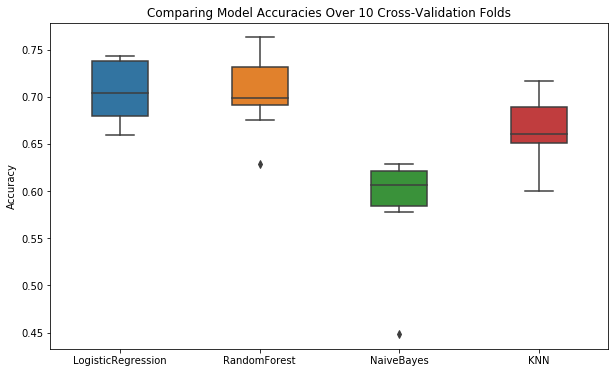

In [202]:
plt.figure(figsize=(10,6))
sns.boxplot(x = resultdf['Model'], y = resultdf['Accuracy'], width = 0.4)
plt.title("Comparing Model Accuracies Over 10 Cross-Validation Folds")
plt.xlabel('')
plt.show()

### Compare model FPR from cross-validation

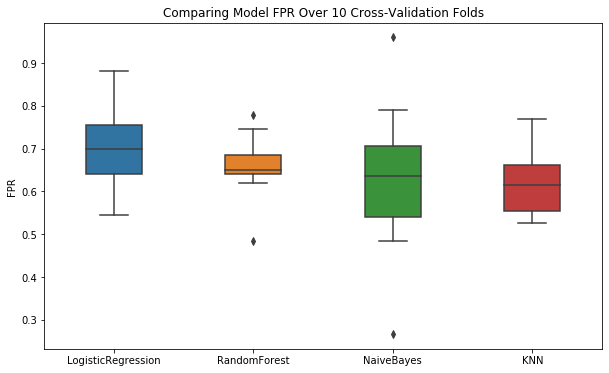

In [203]:
plt.figure(figsize=(10,6))
sns.boxplot(x = resultdf2['Model'], y = resultdf2['FPR'], width = 0.4)
plt.title("Comparing Model FPR Over 10 Cross-Validation Folds")
plt.xlabel('')
plt.show()

#### It looks like KNN does a better job at avoiding the misclassification of drafted athletes (FPR) as mentioned above

### Start significance testing

In [204]:
# Levene's Test
levenep = levene(logacc, rfacc, gnbacc, knnacc)[1]

# Run ANOVA if No Violation
if levenep > 0.05:
    anova = f_oneway(logacc, rfacc, gnbacc, knnacc)[1]
    
    # Run Tukey's Test if Significant to Find Which Group(s) Differs
    if anova < 0.05:
      
        # Tukey
        print(pairwise_tukeyhsd(resultdf['Accuracy'], resultdf['Model']))

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
               KNN LogisticRegression   0.0427 0.1091 -0.0066  0.0919  False
               KNN         NaiveBayes  -0.0726 0.0018 -0.1219 -0.0234   True
               KNN       RandomForest   0.0422 0.1157 -0.0071  0.0914  False
LogisticRegression         NaiveBayes  -0.1153  0.001 -0.1646 -0.0661   True
LogisticRegression       RandomForest  -0.0005    0.9 -0.0498  0.0487  False
        NaiveBayes       RandomForest   0.1148  0.001  0.0656   0.164   True
----------------------------------------------------------------------------


#### It looks like KNN vs. NaiveBayes, Logistic Regression vs. Naive Bayes, and Naive Bayes vs. Random Forest are significantly different. Knowing this and the model mean accuracies over all the folds, either Logistic Regression or Random Forest would be considered the best model.

### Display most important features for Random Forest model

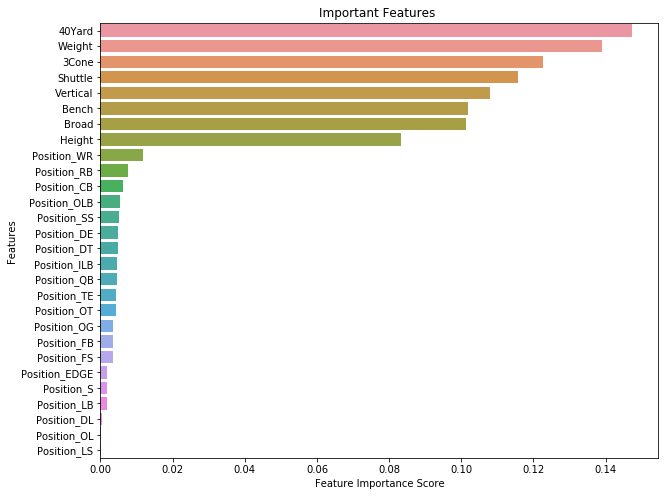

In [212]:
feature_imp = pd.Series(rf.feature_importances_, index = dfclean.drop('Drafted',axis=1).columns).sort_values(ascending = False)

plt.figure(figsize=(10,8))
sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features ")
plt.show()

#### 40-yard dash is very important to being draft, along with an athlete's weight and 3-cone time.